In [1]:
#Importing all the necessary Libraries
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras
import tensorflow as tf
import keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, Reshape, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from PIL import Image
from PIL import UnidentifiedImageError

from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [2]:
import os
os.environ['KAGGLE_USERNAME'] = 'shashankreddy3338'
os.environ['KAGGLE_KEY'] = '4452c4a76d8a24d204257f950b1679ad'

!kaggle datasets download -d jamesnogra/face-mask-usage
!unzip -q face-mask-usage.zip


 51% 7.00M/13.8M [00:00<00:00, 63.4MB/s]
100% 13.8M/13.8M [00:00<00:00, 74.0MB/s]


In [3]:
fully_covered = os.listdir('/content/fully_covered')
not_covered = os.listdir('/content/not_covered')
not_face = os.listdir('/content/not_face')
partially_covered = os.listdir('/content/partially_covered')

In [4]:
img_w, img_h = 150, 150
X = []
y = []

In [5]:
for i in fully_covered:
    try:
        img = Image.open("/content/fully_covered/" + i).convert('RGB')
        img = img.resize((img_w,img_h))
        X.append(np.asarray(img))
        y.append(0)
    except UnidentifiedImageError:
        pass

In [6]:
for i in not_covered:
    try:
        img = Image.open("/content/not_covered/" + i).convert('RGB')
        img = img.resize((img_w,img_h))
        X.append(np.asarray(img))
        y.append(1)
    except UnidentifiedImageError:
        pass

In [7]:
for i in not_face:
    try:
        img = Image.open("/content/not_face/" + i).convert('RGB')
        img = img.resize((img_w,img_h))
        X.append(np.asarray(img))
        y.append(2)
    except UnidentifiedImageError:
        pass

In [8]:
for i in partially_covered:
    try:
        img = Image.open("/content/partially_covered/" + i).convert('RGB')
        img = img.resize((img_w,img_h))
        X.append(np.asarray(img))
        y.append(3)
    except UnidentifiedImageError:
        pass

In [9]:
X = np.asarray(X)
y = np.asarray(y)
print(X.shape, y.shape)

(6621, 150, 150, 3) (6621,)


In [10]:
x = X.astype('float32')
x /= 255

In [11]:
num_classes = 4

labels = keras.utils.to_categorical(y, num_classes)
print(labels[0])

[1. 0. 0. 0.]


In [12]:
x_train1, x_test, y_train1, y_test = train_test_split(x, labels, test_size = 0.3, random_state=5)
x_train,x_val,y_train,y_val=train_test_split(x_train1,y_train1,test_size=0.3,random_state=5)

print('Number of train: {}'.format(len(x_train)))
print('Number of validation: {}'.format(len(x_val)))
print('Number of test: {}'.format(len(x_test)))

Number of train: 3243
Number of validation: 1391
Number of test: 1987


In [13]:
# Loading the InceptionV3 model
base_model = tf.keras.applications.InceptionV3(input_shape=(150,150,3),include_top=False,weights="imagenet")

87910968/87910968 [==============================] - 0s 0us/step


In [14]:
#Freezing the layers of the model
for layer in base_model.layers[:-10]:
    layer.trainable=False

In [15]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 3, 3, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 128)               2359424   
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 4)                 516       
                                                                 
Total params: 24,179,236
Trainable params: 2,376,644
Non

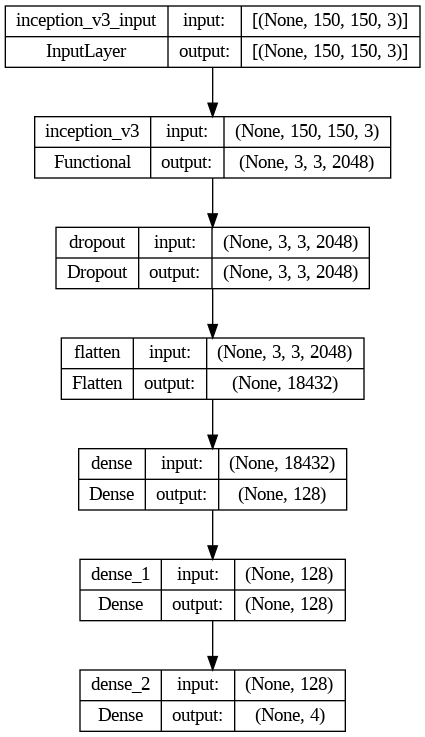

In [16]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

In [17]:
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [18]:
METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [19]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.50, min_lr = 1e-6)
mcp = ModelCheckpoint('model.h5')
es = EarlyStopping(verbose=1, patience=3)

In [20]:
model.compile(optimizer='Adam', loss = tf.keras.losses.CategoricalCrossentropy(),metrics=METRICS)

In [21]:
%time
history=model.fit(x_train,y_train,validation_data=(x_val,y_val),epochs = 10,verbose = 1,callbacks=[lrd,mcp,es])

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.87 µs
Epoch 1/10
102/102 [==============================] - 30s 128ms/step - loss: 0.5214 - accuracy: 0.8976 - precision: 0.9060 - recall: 0.8915 - auc: 0.9716 - f1_score: 0.8970 - val_loss: 0.2483 - val_accuracy: 0.9209 - val_precision: 0.9261 - val_recall: 0.9195 - val_auc: 0.9885 - val_f1_score: 0.9221 - lr: 0.0010
Epoch 2/10
102/102 [==============================] - 7s 71ms/step - loss: 0.1053 - accuracy: 0.9676 - precision: 0.9709 - recall: 0.9655 - auc: 0.9962 - f1_score: 0.9683 - val_loss: 0.1976 - val_accuracy: 0.9511 - val_precision: 0.9550 - val_recall: 0.9461 - val_auc: 0.9911 - val_f1_score: 0.9495 - lr: 0.0010
Epoch 3/10
102/102 [==============================] - 6s 59ms/step - loss: 0.0401 - accuracy: 0.9855 - precision: 0.9876 - recall: 0.9821 - auc: 0.9995 - f1_score: 0.9849 - val_loss: 0.1552 - val_accuracy: 0.9648 - val_precision: 0.9682 - val_recall: 0.9626 - val_auc: 0.9936 - val_f1_score: 0.9642 - lr: 0.001

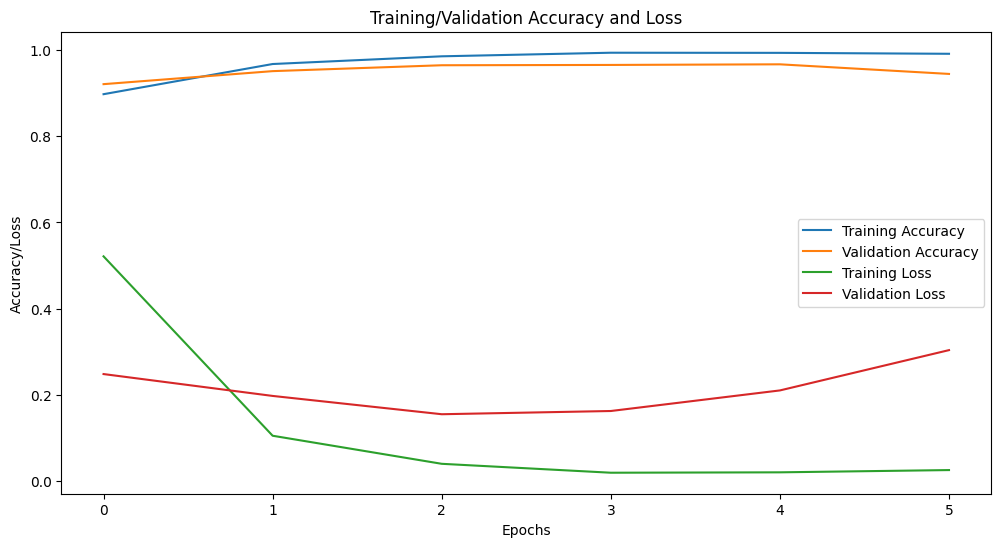

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Plot training accuracy and loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.title('Training/Validation Accuracy and Loss')
plt.legend()
plt.show()




In [23]:
# Predict labels for test data using the trained model
y_pred = (model.predict(x_test) > 0.5).astype("int32")

# Convert true labels to binary labels
y_test_c = np.argmax(y_test, axis=1)

# Define target class names for the confusion matrix
target_names = ["Fully Covered", "Not Covered", "Not Face", "Partially Covered"]

# Compute confusion matrix and plot it
Y_pred = np.argmax(model.predict(x_test),axis=1)
print('Confusion Matrix')
cm = confusion_matrix(y_test_c, Y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

# Print classification report
print('Classification Report')
print(classification_report(y_test_c, Y_pred, target_names=target_names))

63/63 [==============================] - 2s 30ms/step
Confusion Matrix


NameError: ignored

**VGG-16**

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
from sklearn.model_selection import train_test_split

# Create lists of all file paths and corresponding labels
file_paths = []
labels = []

for class_name in ['fully_covered', 'not_covered', 'not_face', 'partially_covered']:
    class_path = f'/content/{class_name}/'
    for file_name in os.listdir(class_path):
        file_path = os.path.join(class_path, file_name)
        file_paths.append(file_path)
        labels.append(class_name)

# Split into training and testing sets
train_file_paths, test_file_paths, train_labels, test_labels = train_test_split(file_paths, labels, test_size=0.2, random_state=42)
